# Sentiment Analysis for stock price prediction

#### Data collection and cleaning

In [411]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emoji
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
# import nltk
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tiwar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiwar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [413]:
from tensorflow.keras.datasets import imdb
import pandas as pd
import numpy as np
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras
from sklearn.model_selection import train_test_split

In [414]:
df = pd.read_csv(r'C:\Users\tiwar\Downloads\StockTwits_Mar-Jun.csv')

In [415]:
df.drop(['Unnamed: 0','id'],axis=1,inplace=True)
data = df[df['senti']!=" "]
data.dropna(inplace=True)
data['senti'].value_counts()

<ipython-input-415-621b8b2919f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Bullish    51231
Bearish    18231
Name: senti, dtype: int64

#Cleaning the data

In [416]:
def cleaned_text(data):
    data.dropna(inplace=True)

    def de_emojify(string):
        tweet = emoji.demojize(string)
        tweet = tweet.replace(":", " ")
        tweet = ' '.join(tweet.split())
        return tweet

    def remove_urls(vTEXT):
        vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
        return (vTEXT)

    def remove_tags(string):
        result = re.sub('<.*?>', '', string)
        return result

    def remove_tags1(string):
        result = re.sub(r'[^\w\s]', ' ', string)
        return result

    def remove_punctuations(string):
        result = ' '.join(re.sub(r"[\.\,\!\?\:\;\-\=]", " ", string).split())
        return result

    data['body'] = data['body'].apply(lambda cw: de_emojify(cw))
    data['length'] = data['body'].apply(lambda x: len(x.split()))
    data['body'] = data['body'].apply(lambda cw: remove_tags(cw))
    data['body']= data['body'].apply(lambda cw : remove_tags1(cw))
    data['body'] = data['body'].apply(lambda cw: remove_punctuations(cw))
    data.dropna(inplace=True)
    data['body'] = data['body'].str.lower()
    data['tokenized body'] = data['body'].apply(nltk.word_tokenize).tolist()
    data = data[data['length']>3]
    data['body'] = data['body'].apply(lambda x:x.replace('AAPL',''))
    return data

In [417]:
data_1 = cleaned_text(data)
data_1.head()

<ipython-input-416-27ad528c28bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
<ipython-input-416-27ad528c28bc>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['body'] = data['body'].apply(lambda cw: de_emojify(cw))
<ipython-input-416-27ad528c28bc>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,created_at,body,senti,length,tokenized body
0,2021-03-04 22:41:36+00:00,aapl people please get serious on your pt s wi...,Bullish,53,"[aapl, people, please, get, serious, on, your,..."
1,2021-03-04 22:42:50+00:00,aapl daily divergence on the daily will it rev...,Bullish,18,"[aapl, daily, divergence, on, the, daily, will..."
2,2021-03-04 22:43:08+00:00,aapl watch video if you want to know what this...,Bullish,18,"[aapl, watch, video, if, you, want, to, know, ..."
5,2021-03-04 22:43:47+00:00,aapl yo man 150 pt,Bullish,5,"[aapl, yo, man, 150, pt]"
8,2021-03-04 22:45:05+00:00,aapl i demand free housing in the spaceship to...,Bullish,17,"[aapl, i, demand, free, housing, in, the, spac..."


In [418]:
reviews_tokenized = data_1['body'].apply(nltk.word_tokenize).tolist()
X_train, X_test,Y_train, Y_test = train_test_split(reviews_tokenized, data_1['senti'], test_size=0.2, random_state = 45)
np.unique(Y_test,return_counts=True)

(array(['Bearish', 'Bullish'], dtype=object), array([3347, 9366], dtype=int64))

In [419]:
Y_train = np.array(list(map(lambda x: 1 if x=="Bullish" else 0, Y_train)))
Y_test = np.array(list(map(lambda x: 1 if x=="Bullish" else 0, Y_test)))

In [420]:
def get_tokenizer(data):
    data = np.array(data, dtype=object)
    tokenizer = Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(data)
    return tokenizer

In [421]:
tokenizer = get_tokenizer(X_train)

In [422]:
words_to_index = tokenizer.word_index
maxLen = 80

In [423]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [424]:
####LSTM
model = keras.Sequential()
#Embedding layer turns vectors of integers into dense real vectors of fixed size
#model.add(layers.Embedding(embedding_matrix_ft.shape[0], embedding_matrix_ft.shape[1],weights=[embedding_matrix_ft], input_length=maxLen))
model.add(layers.Embedding(max_features, 32))
model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))

model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer='l2'))

optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [425]:
def get_data_for_model_prediction (text, tokenizer):
    X_test_indices = tokenizer.texts_to_sequences(text)
    X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
    return X_test_indices

In [426]:
X_train_indices = get_data_for_model_prediction(X_train,tokenizer)
X_train_indices.shape
X_test_indices = get_data_for_model_prediction(X_test,tokenizer)

In [427]:
EPOCHS = 64
BATCH = 256

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit(X_train_indices, Y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_split=0.2,
          verbose = 1,
          callbacks = [early_stop])

Epoch 1/64
159/159 [==============================] - 84s 531ms/step - loss: 0.6156 - accuracy: 0.7418 - val_loss: 0.5959 - val_accuracy: 0.7357
Epoch 2/64
159/159 [==============================] - 87s 546ms/step - loss: 0.5877 - accuracy: 0.7420 - val_loss: 0.5917 - val_accuracy: 0.7357
Epoch 3/64
159/159 [==============================] - 86s 541ms/step - loss: 0.5835 - accuracy: 0.7420 - val_loss: 0.5874 - val_accuracy: 0.7357
Epoch 4/64
159/159 [==============================] - 91s 570ms/step - loss: 0.5770 - accuracy: 0.7427 - val_loss: 0.5544 - val_accuracy: 0.7384
Epoch 5/64
159/159 [==============================] - 87s 550ms/step - loss: 0.4549 - accuracy: 0.8002 - val_loss: 0.4179 - val_accuracy: 0.8237
Epoch 6/64
159/159 [==============================] - 85s 536ms/step - loss: 0.3782 - accuracy: 0.8426 - val_loss: 0.3861 - val_accuracy: 0.8359
Epoch 7/64
159/159 [==============================] - 90s 567ms/step - loss: 0.3497 - accuracy: 0.8568 - val_loss: 0.3857 - val_ac

# Results on test data

In [432]:
_, acc = model.evaluate(X_test_indices, Y_test, batch_size=64, verbose = 0)
print("Testing set accuracy: {:.2f}%".format(acc*100))

Testing set accuracy: 84.76%


# # Sentiment Prediction

In [433]:
df = pd.read_csv(r'C:\Users\tiwar\Downloads\StockteTwits_AAPl_1.csv')

In [430]:
df.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [431]:
df_new = cleaned_text(df)

<ipython-input-416-27ad528c28bc>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['body'] = data['body'].apply(lambda x:x.replace('AAPL',''))


In [434]:
cleaned_data = df_new['body']
data_for_prediction = get_data_for_model_prediction(cleaned_data, tokenizer)
prediction = model.predict(data_for_prediction, batch_size=64)
df_new['score'] = prediction
#df['senti'] = df['senti'].str.replace('Bearish','negative')
#df['senti'] = df['senti'].str.replace('Bullish','positive')

In [436]:
df_test = df_new[df_new['senti']!=" "]

## Testing on 1 year data

In [437]:
df_test['label'] = np.array(list(map(lambda x : 'Bullish' if x > 0.50 else 'Bearish',df_test['score'])))
df_test['label'].head()
df_test['senti'].head()
import sklearn
sklearn.metrics.accuracy_score(df_test['senti'], df_test['label'])

<ipython-input-437-048f58f155c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['label'] = np.array(list(map(lambda x : 'Bullish' if x > 0.50 else 'Bearish',df_test['score'])))


0.8405037637521714

In [438]:
df_new['senti_true'] = df_new['senti']
df_new['senti'] = np.array(list(map(lambda x : 'positive' if x > 0.50 else 'negative',df_new['score'])))

# #Aggregating data on daliy level

In [440]:
import datetime
df_new['created_at'] = df_new['created_at'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00'))
df_new['Hour'] = df_new['created_at'].apply(lambda x:x.hour)
df_new['Month'] = df_new['created_at'].apply(lambda x:x.month)
df_new['Year'] = df_new['created_at'].apply(lambda x:x.year)
df_new['weekday'] = df_new['created_at'].apply(lambda x: x.weekday())
df_new['day'] = df_new['created_at'].apply(lambda x: x.day)
df_new['Date'] = pd.to_datetime(df['created_at']).dt.date


df_current = df_new[ (df_new['Hour'] < 16)]
df_current_2 = df_new[(df_new['Hour'] > 16)]

df_pos_1 = df_current[(df_current['senti']=='positive')]
df_pos_1 = df_pos_1.groupby(['Year','Month','day','weekday','Date'])['body'].count().reset_index()
df_pos_2 = df_current_2[(df_current_2['senti']=='positive')]
df_pos_2 = df_pos_2.groupby(['Year','Month','day','weekday','Date'])['body'].count().reset_index()

df_test = df_current.groupby(['Year','Month','day','weekday','Date'])['body'].count().reset_index()
df_final = df_test.copy(deep=True)
df_test_2 = df_current_2.groupby(['Year','Month','day','weekday','Date'])['body'].count().reset_index()
df_sum = df_current.groupby(['Year','Month','day','weekday','Date'])['score'].sum().reset_index()
df_sum_2 = df_current_2.groupby(['Year','Month','day','weekday','Date'])['score'].sum().reset_index()
total_sum =[]
count =0
pos_count =[]
for i in range(len(df_test)):
    df_final['body'][i] = df_test_2['body'][i] + df_test['body'][i]
    total_sum.append(df_sum_2['score'][i] + df_sum['score'][i])
    pos_count.append(df_pos_2['body'][i] + df_pos_1['body'][i])

df_final['total_score'] = total_sum
df_final['average_score'] = df_final['total_score']/df_final['body']
df_final['pos_count'] = pos_count

<ipython-input-440-688c1ba50b28>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['body'][i] = df_test_2['body'][i] + df_test['body'][i]


In [441]:
df_final['pos_prop'] = df_final['pos_count']/df_final['body']
df_final.head()

,Year,Month,day,weekday,Date,body,total_score,average_score,pos_count,pos_prop
0,2020,6,17,2,2020-06-17,619,486.633606,0.786161,519,0.838449
1,2020,6,18,3,2020-06-18,765,569.742188,0.744761,614,0.802614
2,2020,6,19,4,2020-06-19,600,444.131714,0.740220,470,0.783333
3,2020,6,20,5,2020-06-20,722,540.997009,0.749303,564,0.781163
4,2020,6,21,6,2020-06-21,251,187.757950,0.748040,194,0.772908


# Importing Stocks data

In [442]:
stocks_info = pd.read_csv(r'C:\Users\tiwar\Downloads\tickerdf.csv')

In [443]:
stocks_info['Date'] = pd.to_datetime(stocks_info['Date'], infer_datetime_format=False).dt.date

In [444]:
type(stocks_info['Date'][0])

datetime.date

In [445]:
len(df_final)

311

# Merging stocks and sentiment data for final analysis and prediction

In [446]:
df_final = df_final.merge(stocks_info,how = 'outer',left_on='Date', right_on='Date')

In [447]:
df_final.head()

,Year,Month,day,weekday,Date,body,total_score,average_score,pos_count,pos_prop,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020,6,17,2,2020-06-17,619,486.633606,0.786161,519,0.838449,88.193247,88.255328,87.185041,87.309204,114406400.0,0.0,0.0
1,2020,6,18,3,2020-06-18,765,569.742188,0.744761,614,0.802614,87.264512,87.771101,86.720676,87.343979,96820400.0,0.0,0.0
2,2020,6,19,4,2020-06-19,600,444.131714,0.740220,470,0.783333,88.066604,88.543387,85.709978,86.844833,264476000.0,0.0,0.0
3,2020,6,20,5,2020-06-20,722,540.997009,0.749303,564,0.781163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,6,21,6,2020-06-21,251,187.757950,0.748040,194,0.772908,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [448]:
len(df_final)

311

# Price Prediction

In [885]:
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

In [886]:
i=304
full_df = df_final.copy(deep=True)
full_df['Date'] = pd.to_datetime(full_df.Date)
full_df = full_df.interpolate(method='linear')
result = seasonal_decompose(full_df[['Close']], model='additive', period=7, extrapolate_trend='freq')
full_df['trend'] = result.trend
full_df['seasonal'] = result.seasonal
deltaT = np.array([(full_df.Date[i + 1] - full_df.Date[i]) for i in range(len(full_df)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))
full_df.insert(1, '∆t', deltaT)
full_df.head()

,Year,∆t,Month,day,weekday,Date,body,total_score,average_score,pos_count,pos_prop,Open,High,Low,Close,Volume,Dividends,Stock Splits,trend,seasonal
0,2020,0,6,17,2,2020-06-17,619,486.633606,0.786161,519,0.838449,88.193247,88.255328,87.185041,87.309204,1.144064e+08,0.0,0.0,87.776451,0.068787
1,2020,1 days 00:00:00,6,18,3,2020-06-18,765,569.742188,0.744761,614,0.802614,87.264512,87.771101,86.720676,87.343979,9.682040e+07,0.0,0.0,87.980214,-0.091560
2,2020,1 days 00:00:00,6,19,4,2020-06-19,600,444.131714,0.740220,470,0.783333,88.066604,88.543387,85.709978,86.844833,2.644760e+08,0.0,0.0,88.183976,-0.362318
3,2020,1 days 00:00:00,6,20,5,2020-06-20,722,540.997009,0.749303,564,0.781163,87.793445,88.783438,86.206634,87.602231,2.214657e+08,0.0,0.0,88.228015,-0.147401
4,2020,1 days 00:00:00,6,21,6,2020-06-21,251,187.757950,0.748040,194,0.772908,87.520286,89.023489,86.703289,88.359629,1.784555e+08,0.0,0.0,88.528491,-0.002659


# Correlation of Closing price with total_score and pos_prop

In [451]:
np.corrcoef(full_df['Close'],full_df['total_score'])

array([[1.        , 0.37375825],
       [0.37375825, 1.        ]])

In [452]:
np.corrcoef(full_df['Close'],full_df['pos_prop'])

array([[1.        , 0.38442789],
       [0.38442789, 1.        ]])

In [887]:
np.corrcoef(full_df['Close'],full_df['average_score'])

array([[1.       , 0.4560541],
       [0.4560541, 1.       ]])

In [454]:
np.corrcoef(full_df['Close'],full_df['body'])

array([[1.        , 0.33139081],
       [0.33139081, 1.        ]])

### We could observe some correlation between closing price of stock and average sentiment score for that day

# Multivariate Time series (Forecasting stock price using past prices and sentiment)

In [1263]:
full_df.head()

,Year,∆t,Month,day,weekday,Date,body,total_score,average_score,pos_count,pos_prop,Open,High,Low,Close,Volume,Dividends,Stock Splits,trend,seasonal
0,2020,0,6,17,2,2020-06-17,619,486.633606,0.786161,519,0.838449,88.193247,88.255328,87.185041,87.309204,1.144064e+08,0.0,0.0,87.776451,0.068787
1,2020,1 days 00:00:00,6,18,3,2020-06-18,765,569.742188,0.744761,614,0.802614,87.264512,87.771101,86.720676,87.343979,9.682040e+07,0.0,0.0,87.980214,-0.091560
2,2020,1 days 00:00:00,6,19,4,2020-06-19,600,444.131714,0.740220,470,0.783333,88.066604,88.543387,85.709978,86.844833,2.644760e+08,0.0,0.0,88.183976,-0.362318
3,2020,1 days 00:00:00,6,20,5,2020-06-20,722,540.997009,0.749303,564,0.781163,87.793445,88.783438,86.206634,87.602231,2.214657e+08,0.0,0.0,88.228015,-0.147401
4,2020,1 days 00:00:00,6,21,6,2020-06-21,251,187.757950,0.748040,194,0.772908,87.520286,89.023489,86.703289,88.359629,1.784555e+08,0.0,0.0,88.528491,-0.002659


In [1264]:
df = full_df[full_df['Date'] < '2021-03-27']
train_dates = df['Date']

In [1267]:
cols = list(df[['Close','average_score']])
df_for_training = df[cols].astype(float)

In [1268]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar = scalar.fit(df_for_training)
df_for_training_scaled = scalar.transform(df_for_training)

In [1276]:
trainX =[]
trainY =[]
n_future =1
n_past = 28

In [1277]:
for i in range(n_past, len(df_for_training_scaled) -n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future - 1:i+n_future,0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [1278]:
print(trainX.shape)
print(trainY.shape)

(255, 28, 2)
(255, 1)


In [1279]:
model = tf.keras.models.Sequential()
model.add(LSTM(64, activation="relu", input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation="relu", return_sequences=False))
model.add(Dense(trainY.shape[1]))
optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(trainX, trainY, epochs=400, validation_split=0.1, verbose =1, callbacks = [early_stop])

Epoch 1/400
8/8 [==============================] - 0s 46ms/step - loss: 0.3397 - mae: 0.6789 - val_loss: 0.0802 - val_mae: 0.3622
Epoch 2/400
8/8 [==============================] - 0s 14ms/step - loss: 0.3389 - mae: 0.6780 - val_loss: 0.0795 - val_mae: 0.3605
Epoch 3/400
8/8 [==============================] - 0s 14ms/step - loss: 0.3375 - mae: 0.6765 - val_loss: 0.0786 - val_mae: 0.3581
Epoch 4/400
8/8 [==============================] - 0s 14ms/step - loss: 0.3359 - mae: 0.6748 - val_loss: 0.0777 - val_mae: 0.3557
Epoch 5/400
8/8 [==============================] - 0s 14ms/step - loss: 0.3343 - mae: 0.6731 - val_loss: 0.0766 - val_mae: 0.3529
Epoch 6/400
8/8 [==============================] - 0s 14ms/step - loss: 0.3324 - mae: 0.6712 - val_loss: 0.0757 - val_mae: 0.3503
Epoch 7/400
8/8 [==============================] - 0s 13ms/step - loss: 0.3307 - mae: 0.6694 - val_loss: 0.0747 - val_mae: 0.3478
Epoch 8/400
8/8 [==============================] - 0s 13ms/step - loss: 0.3289 - mae: 0.66

8/8 [==============================] - 0s 14ms/step - loss: 0.2536 - mae: 0.5813 - val_loss: 0.0433 - val_mae: 0.2498
Epoch 64/400
8/8 [==============================] - 0s 14ms/step - loss: 0.2524 - mae: 0.5799 - val_loss: 0.0429 - val_mae: 0.2484
Epoch 65/400
8/8 [==============================] - 0s 14ms/step - loss: 0.2512 - mae: 0.5784 - val_loss: 0.0426 - val_mae: 0.2471
Epoch 66/400
8/8 [==============================] - 0s 14ms/step - loss: 0.2501 - mae: 0.5769 - val_loss: 0.0423 - val_mae: 0.2460
Epoch 67/400
8/8 [==============================] - 0s 14ms/step - loss: 0.2489 - mae: 0.5754 - val_loss: 0.0420 - val_mae: 0.2450
Epoch 68/400
8/8 [==============================] - 0s 13ms/step - loss: 0.2478 - mae: 0.5740 - val_loss: 0.0417 - val_mae: 0.2440
Epoch 69/400
8/8 [==============================] - 0s 13ms/step - loss: 0.2466 - mae: 0.5725 - val_loss: 0.0415 - val_mae: 0.2429
Epoch 70/400
8/8 [==============================] - 0s 13ms/step - loss: 0.2455 - mae: 0.5710 - 

8/8 [==============================] - 0s 13ms/step - loss: 0.1742 - mae: 0.4735 - val_loss: 0.0251 - val_mae: 0.1756
Epoch 126/400
8/8 [==============================] - 0s 14ms/step - loss: 0.1727 - mae: 0.4711 - val_loss: 0.0250 - val_mae: 0.1752
Epoch 127/400
8/8 [==============================] - 0s 13ms/step - loss: 0.1712 - mae: 0.4689 - val_loss: 0.0248 - val_mae: 0.1747
Epoch 128/400
8/8 [==============================] - 0s 13ms/step - loss: 0.1698 - mae: 0.4666 - val_loss: 0.0246 - val_mae: 0.1740
Epoch 129/400
8/8 [==============================] - 0s 13ms/step - loss: 0.1682 - mae: 0.4643 - val_loss: 0.0243 - val_mae: 0.1732
Epoch 130/400
8/8 [==============================] - 0s 13ms/step - loss: 0.1666 - mae: 0.4619 - val_loss: 0.0241 - val_mae: 0.1724
Epoch 131/400
8/8 [==============================] - 0s 13ms/step - loss: 0.1652 - mae: 0.4595 - val_loss: 0.0239 - val_mae: 0.1718
Epoch 132/400
8/8 [==============================] - 0s 13ms/step - loss: 0.1636 - mae: 0.

8/8 [==============================] - 0s 13ms/step - loss: 0.0761 - mae: 0.3053 - val_loss: 0.0174 - val_mae: 0.1536
Epoch 188/400
8/8 [==============================] - 0s 14ms/step - loss: 0.0751 - mae: 0.3034 - val_loss: 0.0174 - val_mae: 0.1536
Epoch 189/400
8/8 [==============================] - 0s 16ms/step - loss: 0.0743 - mae: 0.3016 - val_loss: 0.0173 - val_mae: 0.1537
Epoch 190/400
8/8 [==============================] - 0s 17ms/step - loss: 0.0734 - mae: 0.3000 - val_loss: 0.0173 - val_mae: 0.1537
Epoch 191/400
8/8 [==============================] - 0s 19ms/step - loss: 0.0726 - mae: 0.2983 - val_loss: 0.0172 - val_mae: 0.1537
Epoch 192/400
8/8 [==============================] - 0s 19ms/step - loss: 0.0719 - mae: 0.2966 - val_loss: 0.0172 - val_mae: 0.1537
Epoch 193/400
8/8 [==============================] - 0s 18ms/step - loss: 0.0711 - mae: 0.2949 - val_loss: 0.0172 - val_mae: 0.1537
Epoch 194/400
8/8 [==============================] - 0s 18ms/step - loss: 0.0704 - mae: 0.

In [1280]:
n_future = 28
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods= n_future, freq = '1d').tolist()
forecast = model.predict(trainX[-n_future:])

In [1281]:
#Converting the shape of forecasted array to Xtrain shape to unscale the prediction
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis =-1)
y_pred_future = scalar.inverse_transform(forecast_copies)[:,0]

In [1283]:
error = tf.keras.metrics.mean_absolute_error(full_df['Close'][-28:], y_pred_future).numpy()
print(error)

7.7396674


# Plotting Forecasetd price vs actual price

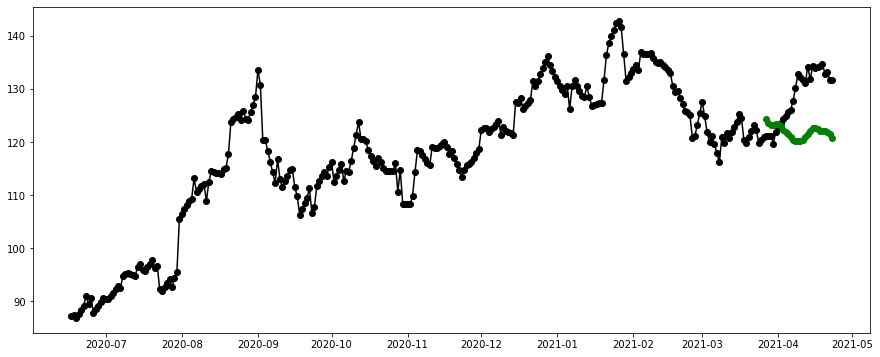

In [1287]:
plt.figure(figsize=(15, 6)) 
price_date = full_df['Date']
price_close = full_df['Close']

plt.plot_date(price_date, price_close, linestyle='solid',color='k')

price_date_2 = full_df['Date'][len(full_df)-len(y_pred_future):]
price_close_2 = y_pred_future
plt.plot_date(price_date_2, price_close_2, linestyle='solid',color='g')

### Looking at the plot we could see that the predictions from our model are not very accurate. One of the main reason for this could be 
### 1. lesser data points. The final multivriate time series model had only 250 data points in the train set
### 2. Given the lesser data points, a simple logistic regression model might yield better results
### 3. We could see that daily average sentiment score had some correlation (0.45) with the closing price. However, relying only on stock_twits for sentiment may not be giving us the actual sentiment. We should also try to include sentiment from other sources such as news headlines, twitter, etc.